In [ ]:
!pip install vtk
!pip install meshio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 5.2 MB/s eta 0:00:00


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os
import vtkmodules.all as vtk
from vtkmodules.util.numpy_support import vtk_to_numpy, numpy_to_vtk
import meshio
from scipy.spatial.distance import cdist
from torchvision import datasets, transforms
import random
from torchsummary import summary

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#device=torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/data_ML4Science'

In [ ]:
fields = {'velocity', 'pressure'}

basis_space, sv_space, Nh_space, nmodes_space = dict(), dict(), dict(), dict()
basis_time, sv_time, Nh_time, nmodes_time = dict(), dict(), dict(), dict()
nmodes = dict()
for field in fields:
    basis_space[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'space_basis.npy'))  # spatial basis
    sv_space[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'space_sv.npy'))  # singular values in space
    Nh_space[field], nmodes_space[field] = basis_space[field].shape  # number of FOM and ROM unknowns in space
    basis_time[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'time_basis.npy'))  # temporal basis
    sv_time[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'time_sv.npy'))  # singular values in time
    Nh_time[field], nmodes_time[field] = basis_time[field].shape  # number of FOM and ROM unknowns in time
    nmodes[field] = nmodes_space[field] * nmodes_time[field]  # total dimension of the reduced basis

# UPDATE VELOCITY BASES TO ACCOUNT FOR SUPREMIZERS AND STABILIZERS
N_supr_space = basis_space['pressure'].shape[1] + 66  # number of extra bases in space for the velocity
N_supr_time = 5  # number of extra bases in time for the velocity

# STORE ORIGINAL NUMBER OF VELOCITY MODES IN THE DICTIONARY
nmodes_space['velocity_full'] = nmodes_space['velocity']
nmodes_time['velocity_full'] = nmodes_time['velocity']
nmodes['velocity_full'] = nmodes['velocity']

# UPDATE THE NUMBER OF VELOCITY MODES TO ACCOUNT FOR SUPREMIZERS AND STABILIZERS
nmodes_space['velocity'] -= N_supr_space
nmodes_time['velocity'] -= N_supr_time
nmodes['velocity'] = nmodes_space['velocity'] * nmodes_time['velocity']

# UPDATE VELOCITY BASES TO ACCOUNT FOR SUPREMIZERS AND STABILIZERS
basis_space['velocity'] = basis_space['velocity'][:, :nmodes_space['velocity']]
basis_time['velocity'] = basis_time['velocity'][:, :nmodes_time['velocity']]

# LOAD NORMED BASIS MATRICES IN SPACE (needed for projections)
basis_space_normed = dict()
#norm = dict()
for field in fields:
    #norm[field] = load_npz(os.path.join('dataset', 'norms', f'norm_{field}.npz'))
    #basis_space_normed[field] = norm[field].dot(basis_space[field])
    #np.save(os.path.join('dataset', 'basis', field, 'basis_space_normed.npy'), basis_space_normed[field])
    basis_space_normed[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'basis_space_normed.npy'))

##################################################################
def project(sol, normed_basis_space, basis_time):
    """ Project a full-order solution in space-time."""
    return (normed_basis_space.T.dot(sol)).dot(basis_time) # !! REMARK: here we need the normed basis in space !!

def expand(sol, basis_space, basis_time):
    """ Expand a reduced-order solution in space-time."""
    return (basis_space.dot(sol)).dot(basis_time.T)

##################################################################

In [ ]:
params = np.load(os.path.join(DATASET_PATH, 'RB_data', 'parameters.npy'))
params = np.delete(params, 2, axis=1)

In [ ]:
n_snaps = None  # change to a number if you want to load only a subset of snapshots
_sol = np.load(os.path.join(DATASET_PATH, 'RB_data', 'solutions.npy'))[:n_snaps]

solutions = dict()

# velocity reduced solutions (with and without supremizers and stabilizers)
solutions['velocity_full'] = np.reshape(_sol[:, :nmodes['velocity_full']],
                                        (-1, nmodes_space['velocity_full'], nmodes_time['velocity_full']))
solutions['velocity'] = solutions['velocity_full'][:, :nmodes_space['velocity'], :nmodes_time['velocity']]

# pressure reduced solutions
solutions['pressure'] = np.reshape(_sol[:, :nmodes['pressure']],
                                   (-1, nmodes_space['pressure'], nmodes_time['pressure']))

In [ ]:
basis_space['velocity'].shape #Vs = Ns *ns

(76974, 39)

In [ ]:
basis_time['velocity'].shape

(1000, 16)

In [ ]:
basis_space['pressure'].shape

(3552, 9)

In [ ]:
basis_time['pressure'].shape

(1000, 19)

In [ ]:
solutions['pressure'].shape

(1950, 9, 19)

In [ ]:
solutions['velocity'].shape

(1950, 39, 16)

In [ ]:
solutions['pressure']= torch.tensor(solutions['pressure'], dtype=torch.float32)
solutions['velocity']= torch.tensor(solutions['velocity'], dtype=torch.float32)
params = torch.tensor(params, dtype=torch.float32)

In [ ]:
class Fluid_Dataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets =  targets

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):

        input = self.inputs[idx]
        output = self.targets[idx]
        return input, output


In [ ]:
N_data=params.shape[0]
indices = torch.randperm(N_data)
ratio_data=0.8
train_size = int(ratio_data * N_data)
train_indices = indices[:train_size]
test_indices=indices[train_size:]

train_params=params[train_indices]
test_params=params[test_indices]

# mean_params=torch.mean(train_params,dim=0)
# std_params=torch.std(train_params,dim=0)
# train_params=(train_params-mean_params)/std_params
# test_params=(test_params-mean_params)/std_params

min_params=torch.min(train_params,dim=0).values
max_params=torch.max(train_params,dim=0).values
train_params=(train_params-min_params)/(max_params-min_params)
test_params=(test_params-min_params)/(max_params-min_params)


train_vel=solutions['velocity'][train_indices]

test_vel=solutions['velocity'][test_indices]

train_press=solutions['pressure'][train_indices]
test_press=solutions['pressure'][test_indices]
print(train_vel[0,0,:])

tensor([151.5633,  48.3194,  -8.4237,  -9.5606,   7.1362,  17.7455,   6.8069,
        -21.4208,  -7.2308,  -3.4512,   3.3204,  -1.0827,  -3.9948,  -0.7475,
         -0.6012,  -0.2947])


In [ ]:
#STANDARDITZAION ALTERNATIVE ZERO
vel_space_mean = torch.mean(train_vel, dim= 0)
vel_space_std = torch.std(train_vel, dim=0)
train_vel = (train_vel - vel_space_mean) / vel_space_std
test_vel =(test_vel - vel_space_mean) / vel_space_std


print(train_vel[0,0,:])


tensor([ 1.7319,  0.2168, -0.5090, -0.7062,  0.7336,  2.1690,  0.4455, -2.7250,
        -1.2003, -0.4249,  1.8618, -1.7595, -0.5973, -0.1114,  0.1245,  0.8888])


In [ ]:
print(train_vel.mean())
print(test_vel.mean())

tensor(6.3876e-10)
tensor(0.0003)


In [ ]:

#STANDARDITZAION ALTERNATIVE ONE
vel_space_max = torch.max(train_vel, dim= 0).values
vel_space_min = torch.min(train_vel, dim=0).values
train_vel = (train_vel - vel_space_min*0.95) / (1.05*vel_space_max - 0.95*vel_space_min)
test_vel =(test_vel - vel_space_min*0.95) / (1.05*vel_space_max - 0.95*vel_space_min)



print(train_vel[0,0,:])

tensor([0.5353, 0.5221, 0.3111, 0.2364, 0.6274, 0.6984, 0.5448, 0.0476, 0.1946,
        0.2977, 0.6426, 0.3657, 0.6563, 0.7023, 0.3109, 0.6751])


In [ ]:
train_params.shape

In [ ]:
test_params.shape

In [ ]:
train_vel.shape

In [ ]:
test_vel.shape

In [ ]:
#IGNORE THIS FOR THE MOMENT
class MLP_press_ConvAutoencoder(torch.nn.Module):
    def __init__(self, parameters=3, dim_1=39, dim_2=16, dim_1_reduced=18, dim_2_reduced=8, L=4, K=256):
        super(MLP_press_ConvAutoencoder, self).__init__()

        self.mlp = torch.nn.Sequential(
            *[layer for i in range(L) for layer in [
                torch.nn.Linear(parameters if i == 0 else K, K),
                torch.nn.LayerNorm(K),
                torch.nn.GELU(),
            ]],
            torch.nn.Linear(K, dim_1_reduced * dim_2_reduced),
            torch.nn.Unflatten(1, (dim_1_reduced, dim_2_reduced))  # Reshaping to (-1, dim_1_reduced, dim_2_reduced)
        )

        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # (batch_size, 1, dim_1, dim_2) -> (batch_size, 16, 20, 8)
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (batch_size, 16, 20, 8) -> (batch_size, 32, 10, 4)
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ReLU(),
            torch.nn.Flatten(),  # (batch_size, 32, 10, 4) -> (batch_size, 1280)
            torch.nn.Linear(32*10*4, dim_1_reduced * dim_2_reduced),  # (batch_size, 1280) -> (batch_size, dim_1_reduced * dim_2_reduced)
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (dim_1_reduced , dim_2_reduced))  # Reshape to (batch_size, dim_1_reduced, dim_2_reduced)
        )

        # Decoder
        self.decoder = torch.nn.Sequential(
      torch.nn.Flatten(1),
      torch.nn.Linear(18 * 8, 32 * 10 * 4),  # (batch_size, dim_1_reduced * dim_2_reduced) -> (batch_size, 32*10*4)
      torch.nn.BatchNorm1d(32 * 10 * 4),  # Batch normalization before ReLU
      torch.nn.ReLU(),
      torch.nn.Unflatten(1, (32, 10, 4)),  # (batch_size, 32*10*4) -> (batch_size, 32, 10, 4)
      torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=(1, 1)),  # (batch_size, 32, 10, 4) -> (batch_size, 16, 20, 8)
      torch.nn.BatchNorm2d(16),  # Batch normalization before ReLU
      torch.nn.ReLU(),
      torch.nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=(0, 1)),  # (batch_size, 16, 20, 8) -> (batch_size, 1, 39, 16)

)


    def forward(self, par, out):
        Z1 = self.mlp(par)  # (dim_1_reduced * dim_2_reduced)

        out_squeezed = out.unsqueeze(1)
          # Adding channel dimension to input
        Z2 = self.encoder(out_squeezed)  # (dim_1_reduced * dim_2_reduced)

        Z3 = self.decoder(Z2) # (batch_siz, 1, dim_1, dim_2)
        Z3=Z3.squeeze(1)  # (batch_siz, dim_1, dim_2)

        return Z1, Z2, Z3

    def predict(self, par):
        Z = self.mlp(par)  # (dim_1_reduced * dim_2_reduced)
        Z = self.decoder(Z)  # (batch_size, 1, dim_1, dim_2)
        Z=Z.squeeze(1)
        return Z



In [ ]:

model = MLP_press_ConvAutoencoder()
  # Valori casuali tra 0 e 1
z1, z2, z3= model.forward(train_params,train_vel)

In [ ]:
z1.shape

torch.Size([1560, 18, 8])

In [ ]:
z2.shape

torch.Size([1560, 18, 8])

In [ ]:
z3.shape

torch.Size([1560, 39, 16])

In [ ]:
#I'M USING THIS AT THE MOMENT

class MLP_press_ConvAutoencoder_2(torch.nn.Module):
    def __init__(self, parameters=3, dim_1=39, dim_2=16, dim_reduced=256, L=4, K=256):
        super(MLP_press_ConvAutoencoder_2, self).__init__()

        self.mlp = torch.nn.Sequential(
            *[layer for i in range(L) for layer in [
                torch.nn.Linear(parameters if i == 0 else K, K),
                torch.nn.LayerNorm(K),
                torch.nn.ReLU(),
            ]],
            torch.nn.Linear(K, dim_reduced), #(batch_size, K) -> (batch_size, dim_reduced)
            torch.nn.LayerNorm(dim_reduced),#########################
            torch.nn.ReLU()#########################################

        )

        # Encoder

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=1),  # (batch_size, 1, dim_1, dim_2) -> (batch_size, 64, 19, 7)
            torch.nn.LayerNorm([32,19,7]),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # (batch_size, 64, 19, 7) -> (batch_size, 128, 10, 4)
            torch.nn.LayerNorm([64,10,4]),
            torch.nn.ReLU(),
            torch.nn.Flatten(),      #(batch_size, 128, 10, 4) -> (batch_size, 128 x 10 x 4)
            torch.nn.Linear(64*10*4, 256),    #(batch_size, 128 x 10 x 4) ->  batch_size, 256)
            torch.nn.LayerNorm(256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, dim_reduced),  #(batch_size, 256) ->  (batch_size, dim_reduced)
            torch.nn.LayerNorm(dim_reduced),
            torch.nn.ReLU(),

        )


        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(dim_reduced, 256),    # (batch_size, dim_reduced)-> #(batch_size, 256)
            torch.nn.LayerNorm(256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64*10*4), # (batch_size, 256)-> #(batch_size, 128*10*4)
            torch.nn.LayerNorm(64*10*4),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (64, 10, 4)),      #(batch_size, 128*10*4) -> (batch_size, 128, 10, 4)
            torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(0, 0)), # (batch_size, 128, 10, 4) -> # (batch_size, 64, 19, 7)
            torch.nn.LayerNorm([32,19,7]),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 1, kernel_size=5, stride=2, padding=1, output_padding=(0, 1)),   # -> (batch_size, 64, 19, 7) --> (batch_size, 1, dim_1, dim_2)
            torch.nn.LayerNorm([1,39,16]),
            torch.nn.Sigmoid() #LEVAREEEEEEEE SE NON MIN MAX
            #-------->LEVAREEEEEEEE SE NON MIN MAX
            #-------->LEVAREEEEEEEE SE NON MIN MAX
            #-------->LEVAREEEEEEEE SE NON MIN MAX
            #-------->LEVAREEEEEEEE SE NON MIN MAX
            #-------->LEVAREEEEEEEE SE NON MIN MAX
            #-------->LEVAREEEEEEEE SE NON MIN MAX
        )


    def forward(self, par, out):
        Z1 = self.mlp(par)  # (batch_size, dim_reduced)

        out_squeezed = out.unsqueeze(1) #(batch_size x 39 x 16) -> #(batch_size x 1 x 39 x 16)
        Z2 = self.encoder(out_squeezed)  # (batch_size, dim_reduced)

        Z3 = self.decoder(Z2) # (batch_siz, 1, dim_1, dim_2)
        Z3=Z3.squeeze(1)  # (batch_siz, dim_1, dim_2)

        return Z1, Z2, Z3

    def predict(self, par):
        Z = self.mlp(par)  # (dim_1_reduced * dim_2_reduced)
        Z = self.decoder(Z)  # (batch_size, 1, dim_1, dim_2)
        Z=Z.squeeze(1)
        return Z

  ######################################################################################

class MLP_press_ConvAutoencoder_3(torch.nn.Module):
    def __init__(self, activation, pooling, K_comb, L_c, L_l, dim_1=39, dim_2=16, dim_reduced=128, K=256):
        super(MLP_press_ConvAutoencoder_3, self).__init__()

        if L_c == 1:
            dim_post_encoder = 4864
            tuple_dec=[(32,19,8),(39,16)]
        elif L_c == 2:
            dim_post_encoder = 2304
            tuple_dec=[(64,9,4),(19,8),(39,16)]
        elif L_c == 3:
            dim_post_encoder = 1024
            tuple_dec=[(128,4,2),(9,4),(19,8),(39,16)]

        self.mlp = torch.nn.Sequential(
            *[layer for i in range(4) for layer in [
                torch.nn.Linear(3 if i == 0 else K, K),
                torch.nn.LayerNorm(K),
                torch.nn.GELU(),
            ]],
            torch.nn.Linear(K, dim_reduced), #(batch_size, K) -> (batch_size, dim_reduced)

            torch.nn.LayerNorm(dim_reduced),#############################
            torch.nn.GELU()#############################################

        )

        self.activation=torch.nn.ReLU if activation=='relu' else torch.nn.GELU
        self.pooling=torch.nn.MaxPool2d if pooling=='max' else torch.nn.AvgPool2d
        initial_h=39 ###########################
        initial_w=16 ###########################

        # Encoder
        self.encoder = torch.nn.Sequential(
            *[layer for i in range(L_c) for layer in [
                torch.nn.Conv2d(1 if i == 0 else 2**(i-1)*32, 2**(i)*32, kernel_size=K_comb[0], stride=K_comb[1], padding=K_comb[2]),
                torch.nn.LayerNorm([2**(i)*32,initial_h//(2**i),initial_w//(2**i)]), ###############################
                self.activation(),
                self.pooling(2,2)
            ]],
            torch.nn.Flatten(),
            *[layer for i in range(L_l) for layer in [
                torch.nn.Linear(dim_post_encoder if i==0 else dim_reduced*(L_l-i+1), dim_reduced*(L_l-i)),
                torch.nn.LayerNorm(dim_reduced*(L_l-i)),
                self.activation()
            ]],

        )

        self.decoder = torch.nn.Sequential(
            *[layer for i in range(L_l-1,-1,-1) for layer in [
                torch.nn.Linear(dim_reduced*(L_l-i), dim_post_encoder if i==0 else dim_reduced*(L_l-i+1)),
                torch.nn.LayerNorm(dim_post_encoder if i==0 else dim_reduced*(L_l-i+1)),
                self.activation()
            ]],
            torch.nn.Unflatten(1, tuple_dec[0]),
            *[layer for i in range(L_c-1) for layer in [
                torch.nn.Upsample(size=tuple_dec[i+1]),
                torch.nn.ConvTranspose2d(2**(L_c-i-1)*32, 2**(L_c-i-2)*32, kernel_size=K_comb[0], stride=K_comb[1], padding=K_comb[2]),
                torch.nn.LayerNorm([2**(L_c-i-2)*32,*tuple_dec[i+1]]), ###############################
                self.activation(),
            ]],
            torch.nn.Upsample(size=tuple_dec[-1]),
            torch.nn.ConvTranspose2d(32, 1, kernel_size=K_comb[0], stride=K_comb[1], padding=K_comb[2]),
            # torch.nn.Sigmoid()
        )



    def forward(self, par, out):
        Z1 = self.mlp(par)  # (batch_size, dim_reduced)

        out_squeezed = out.unsqueeze(1) #(batch_size x 39 x 16) -> #(batch_size x 1 x 39 x 16)

        # print(out_squeezed.shape)
        Z2 = self.encoder(out_squeezed)  # (batch_size, dim_reduced)
        # print(Z2.shape,Z1.shape)

        # print(torch.norm(torch.std(Z1,dim=1)-torch.std(Z2,dim=1)).item()/torch.norm(torch.std(Z1,dim=0)).item())
        # print(torch.norm(torch.mean(Z1,dim=1)-torch.mean(Z2,dim=1)).item()/torch.norm(torch.mean(Z1,dim=0)).item())
        # print(torch.norm(torch.min(Z1,dim=1).values-torch.min(Z2,dim=1).values).item()/torch.norm(torch.min(Z1,dim=0).values).item())
        # print(torch.norm(torch.max(Z1,dim=1).values-torch.max(Z2,dim=1).values).item()/torch.norm(torch.max(Z1,dim=0).values).item())

        Z3 = self.decoder(Z2) # (batch_siz, 1, dim_1, dim_2)
        Z3=Z3.squeeze(1)  # (batch_siz, dim_1, dim_2)

        return Z1, Z2, Z3

    def predict(self, par):
        Z = self.mlp(par)  # (dim_1_reduced * dim_2_reduced)
        Z = self.decoder(Z)  # (batch_size, 1, dim_1, dim_2)
        Z=Z.squeeze(1)
        return Z



class ResidualBlock_enc(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        ### SOLUTION
        self.C1 = torch.nn.Conv2d(
            in_channels,
            out_channels,
            3,
            stride=stride,
            padding=1,
        )
        self.N1 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.R1 = torch.nn.ReLU()
        self.C2 = torch.nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.N2 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.R2 = torch.nn.ReLU()

        self.has_skip_conv = stride != 1 or in_channels != out_channels
        if self.has_skip_conv:
            self.C3 = torch.nn.Conv2d(
                in_channels,
                out_channels,
                3,
                stride=stride,
                padding=1,
            )
            self.N3 = torch.nn.BatchNorm2d(num_features=out_channels)

    def forward(self, x):
        skip_x = x

        x = self.C1(x)
        x = self.N1(x)
        x = self.R1(x)
        x = self.C2(x)
        x = self.N2(x)

        if self.has_skip_conv:
            skip_x = self.C3(skip_x)
            skip_x = self.N3(skip_x)

        x = self.R2(x)# + skip_x)
        return x


class ResidualBlock_dec(torch.nn.Module):
    def __init__(self, in_channels, out_channels, h_in, h_out, w_in, w_out, stride):
        super().__init__()

        op_h=h_out-((h_in-1)*stride-2*1+3)
        op_w=w_out-((w_in-1)*stride-2*1+3)

        self.C1 = torch.nn.ConvTranspose2d(
            in_channels,
            out_channels,
            3,
            stride=stride,
            padding=1,
            output_padding=(op_h,op_w)
        )
        self.N1 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.R1 = torch.nn.ReLU()
        self.C2 = torch.nn.ConvTranspose2d(out_channels, out_channels, 3, padding=1)
        self.N2 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.R2 = torch.nn.ReLU()

        self.has_skip_conv = stride != 1 or in_channels != out_channels
        if self.has_skip_conv:
            self.C3 = torch.nn.ConvTranspose2d(
                in_channels,
                out_channels,
                3,
                stride=stride,
                padding=1,
                output_padding=(op_h,op_w)
            )
            self.N3 = torch.nn.BatchNorm2d(num_features=out_channels)

    def forward(self, x):
        skip_x = x

        x = self.C1(x)
        x = self.N1(x)
        x = self.R1(x)
        x = self.C2(x)
        x = self.N2(x)

        if self.has_skip_conv:
            skip_x = self.C3(skip_x)
            skip_x = self.N3(skip_x)

        x = self.R2(x )#+ skip_x)
        return x


class MLP_press_ConvAutoencoder_4(torch.nn.Module):
    def __init__(self, activation, pooling, K_comb, L_c, L_l, dim_1=39, dim_2=16, dim_reduced=128, K=256):
        super(MLP_press_ConvAutoencoder_4, self).__init__()

        if L_c == 1:
            dim_post_encoder = 5120
            tuple_dec=[(32,20,8),(39,16)]
        elif L_c == 2:
            dim_post_encoder = 2560
            tuple_dec=[(64,10,4),(20,8),(39,16)]
        elif L_c == 3:
            dim_post_encoder = 1280
            tuple_dec=[(128,5,2),(10,4),(20,8),(39,16)]

        self.mlp = torch.nn.Sequential(
            *[layer for i in range(4) for layer in [
                torch.nn.Linear(3 if i == 0 else K, K),
                torch.nn.LayerNorm(K),
                torch.nn.GELU(),
            ]],
            torch.nn.Linear(K, dim_reduced), #(batch_size, K) -> (batch_size, dim_reduced)

        )

        self.activation=torch.nn.ReLU if activation=='relu' else torch.nn.GELU
        self.pooling=torch.nn.MaxPool2d if pooling=='max' else torch.nn.AvgPool2d
        initial_h=39 ###########################
        initial_w=16 ###########################

        channel_list=[(1,32),(32,64),(64,128)]
        list_dec=[(32,1,20,39,8,16),(64,32,10,20,4,8),(128,64,5,10,2,4)]

        ###############
        self.blocks_enc = torch.nn.ModuleList([ResidualBlock_enc(*channel_list[i],stride=2) for i in range(L_c)])
        self.encoder_mlp = torch.nn.Sequential(
            torch.nn.Flatten(),
            *[layer for i in range(L_l) for layer in [
                torch.nn.Linear(dim_post_encoder if i==0 else dim_reduced*(L_l-i+1), dim_reduced*(L_l-i)),
                torch.nn.LayerNorm(dim_reduced*(L_l-i)),
                self.activation()
            ]],

        )
        ###############

        ###############
        self.decoder_mlp = torch.nn.Sequential(
            *[layer for i in range(L_l-1,-1,-1) for layer in [
                torch.nn.Linear(dim_reduced*(L_l-i), dim_post_encoder if i==0 else dim_reduced*(L_l-i+1)),
                torch.nn.LayerNorm(dim_post_encoder if i==0 else dim_reduced*(L_l-i+1)),
                self.activation()
            ]],
            torch.nn.Unflatten(1, tuple_dec[0]),
        )
        self.blocks_dec = torch.nn.ModuleList([ResidualBlock_dec(*list_dec[L_c-1-i],stride=2) for i in range(L_c)])
        self.sigmoid=torch.nn.Sigmoid()
        ###############

    def forward(self, par, out):
        Z1 = self.mlp(par)

        Z2 = out.unsqueeze(1)
        for blocks in self.blocks_enc:
            Z2=blocks(Z2)
        Z2 = self.encoder_mlp(Z2)

        Z3 = self.decoder_mlp(Z2)
        for block in self.blocks_dec:
            Z3=block(Z3)
        Z3=self.sigmoid(Z3)
        Z3=Z3.squeeze(1)

        return Z1, Z2, Z3

    def predict(self, par):
        Z = self.mlp(par)
        Z = self.decoder_mlp(Z)
        for block in self.blocks_dec:
            Z=block(Z)
        Z=self.sigmoid(Z)
        Z=Z.squeeze(1)
        return Z

class MLP_press_ConvAutoencoder_5(torch.nn.Module):
    def __init__(self, dim_reduced=128, K=256):
        super(MLP_press_ConvAutoencoder_5, self).__init__()


        self.mlp = torch.nn.Sequential(
            *[layer for i in range(4) for layer in [
                torch.nn.Linear(3 if i == 0 else K, K),
                torch.nn.LayerNorm(K),
                torch.nn.GELU(),
            ]],
            torch.nn.Linear(K, dim_reduced), #(batch_size, K) -> (batch_size, dim_reduced)

            torch.nn.LayerNorm(dim_reduced),#############################
            torch.nn.GELU()#############################################

        )


        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(39*16,39*8),
            torch.nn.LayerNorm(39*8),
            torch.nn.GELU(),
            torch.nn.Linear(39*8,39*8),
            torch.nn.LayerNorm(39*8),
            torch.nn.GELU(),
            torch.nn.Linear(39*8,39*4),
            torch.nn.LayerNorm(39*4),
            torch.nn.GELU(),
            torch.nn.Linear(39*4,39*4),
            torch.nn.LayerNorm(39*4),
            torch.nn.GELU(),
            torch.nn.Linear(39*4,dim_reduced),
            torch.nn.LayerNorm(dim_reduced),
            torch.nn.GELU(),

        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(dim_reduced,39*4),
            torch.nn.LayerNorm(39*4),
            torch.nn.GELU(),
            torch.nn.Linear(39*4,39*4),
            torch.nn.LayerNorm(39*4),
            torch.nn.GELU(),
            torch.nn.Linear(39*4,39*8),
            torch.nn.LayerNorm(39*8),
            torch.nn.GELU(),
            torch.nn.Linear(39*8,39*8),
            torch.nn.LayerNorm(39*8),
            torch.nn.GELU(),
            torch.nn.Linear(39*8,39*16),
            # torch.nn.LayerNorm(39*16),
            # torch.nn.Sigmoid()
        )

        # self.encoder = torch.nn.Sequential(
        #     torch.nn.Flatten(),
        #     torch.nn.Linear(39*16,dim_reduced),
        #     torch.nn.LayerNorm(dim_reduced),
        #     torch.nn.GELU()

        # )

        # self.decoder = torch.nn.Sequential(
        #     torch.nn.Linear(dim_reduced,39*16),
        #     torch.nn.LayerNorm(39*16),
        #     torch.nn.Sigmoid()
        # )



    def forward(self, par, out):
        Z1 = self.mlp(par)

        Z2 = self.encoder(out)

        Z3 = self.decoder(Z2)
        Z3 = Z3.view(-1, 39, 16)

        return Z1, Z2, Z3

    def predict(self, par):
        Z = self.mlp(par)
        Z = self.decoder(Z)
        Z = Z.view(-1, 39, 16)
        return Z


class MLP_pura(torch.nn.Module):
    def __init__(self, dim_reduced=128, K=256):
        super(MLP_pura, self).__init__()


        self.mlp = torch.nn.Sequential(
            *[layer for i in range(4) for layer in [
                torch.nn.Linear(3 if i == 0 else K, K),
                torch.nn.LayerNorm(K),
                torch.nn.GELU(),
            ]],
            torch.nn.Linear(K, 39*16), #(batch_size, K) -> (batch_size, dim_reduced)

        )



    def forward(self, par):
        Z = self.mlp(par)
        Z = Z.view(-1, 39, 16)
        return Z

In [ ]:

model = MLP_press_ConvAutoencoder_2()
  # Valori casuali tra 0 e 1
z1, z2, z3= model.forward(train_params,train_vel)

In [ ]:
z1.shape

torch.Size([1560, 128])

In [ ]:
z2.shape

torch.Size([1560, 128])

In [ ]:
# vel_space_mean=vel_space_mean.to('cuda')
# vel_space_std=vel_space_std.to('cuda')
vel_space_min=vel_space_min.to('cuda')
vel_space_max=vel_space_max.to('cuda')


In [ ]:

#TODO: normalize input of encoder

def train_encoder_decoder_epoch(model, device, train_loader, optimizer, epoch, criterion):
    model.train()  # Important set model to train mode (affects dropout, batch norm etc)

    loss_history = []
    accuracy_history = []
    loss_history_enc_dec = []
    loss_history_mlp_encoder = []
    for batch_idx, (data, target) in enumerate(train_loader):


        data=data.to(device)
        target=target.to(device)

        Z1, Z2, Z3 = model.forward(data, target)

        assert Z3.shape == target.shape
        assert Z1.shape == Z2.shape

        # ###########################
        # target=target*vel_space_std+vel_space_mean
        # Z3=Z3*vel_space_std+vel_space_mean
        # ###########################
        target=target*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min
        Z3=Z3*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min
        ##############################

        Z3_flattened = Z3.flatten(1)
        target_fattened = target.flatten(1)

        loss_enc_dec = criterion(target_fattened, Z3_flattened)
        loss_mlp_encoder = criterion(Z1, Z2)


        loss =  loss_enc_dec + 10*loss_mlp_encoder

        optimizer.zero_grad()  # Zero the gradients

        loss.backward()        # Backpropagation
        optimizer.step()       # Update the weights

        loss_history_enc_dec.append(loss_enc_dec.item())
        loss_history_mlp_encoder.append(loss_mlp_encoder.item())
        loss_history.append(loss.item())

    return loss_history, loss_history_enc_dec, loss_history_mlp_encoder

@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()  # Important set model to eval mode (affects dropout, batch norm etc)
    test_loss = 0
    test_rel_loss = 0
    for data, target in val_loader:

        data, target = data.to(device), target.to(device)
        output = model.predict(data)
        assert output.shape == target.shape

        # #####################
        # output=output*vel_space_std+vel_space_mean
        # target=target*vel_space_std+vel_space_mean
        # #####################
        output=output*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min
        target=target*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min
        ##############################

        output_flattened = output.flatten(1)
        target_flattened = target.flatten(1)
        test_loss += criterion(output_flattened, target_flattened).item() * len(data)

        test_rel_loss += ((torch.norm((output-target).view(output.shape[0], -1), dim=1, p=2)/torch.norm((target).view(output.shape[0], -1), dim=1, p=2)).sum()).item()
    test_loss /= len(val_loader.dataset)
    test_rel_loss /= len(val_loader.dataset)

    print(
         "Test set: Average loss: {:.4f} Average relative error: {:.4f}".format(
           test_loss, test_rel_loss
        )
    )
    return test_loss,test_rel_loss


def run_vel_training_encoder_decoder(model_encoder_decoder,num_epochs, lr, batch_size, device="cuda"):

    train_vel_DataSet = Fluid_Dataset(train_params, train_vel)
    test_vel_DataSet = Fluid_Dataset(test_params, test_vel)

    train_loader = torch.utils.data.DataLoader(
        train_vel_DataSet,
        batch_size=batch_size,
        shuffle=True,  # Can be important for training
        pin_memory=torch.cuda.is_available(),
        drop_last=True,
        num_workers=2,
    )
    val_loader = torch.utils.data.DataLoader(
        test_vel_DataSet,
        batch_size=batch_size,
    )

    # ===== Model, Optimizer and Criterion =====
    model_encoder_decoder = model_encoder_decoder.to(device=device)
    optimizer_encoder_decoder  = torch.optim.Adam(
        model_encoder_decoder.parameters(),
        lr=lr,
        weight_decay=0
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_encoder_decoder, mode='min', factor=0.5, patience=10
    )
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer_encoder_decoder, gamma=0.95)
    criterion_mlp = torch.nn.functional.mse_loss

    # ===== Train Model =====
    train_loss_history = []
    train_loss_enc_dec_history = []
    train_loss_mlp_enc_history = []
    val_loss_history = []
    val_rel_loss_history = []

    for epoch in range(1, num_epochs + 1):
        train_loss, trai_loss_enc_dec, train_loss_mlp_enc = train_encoder_decoder_epoch(
            model_encoder_decoder, device, train_loader, optimizer_encoder_decoder, epoch, criterion_mlp
        )
        print("LOSS_ENC: ", sum(trai_loss_enc_dec)/len(trai_loss_enc_dec), " LOSS_MLP: ", sum(train_loss_mlp_enc)/len(train_loss_mlp_enc))
        train_loss_history.extend(train_loss)
        train_loss_enc_dec_history.extend(trai_loss_enc_dec)
        train_loss_mlp_enc_history.extend(train_loss_mlp_enc)

        val_loss,val_rel_loss= validate(model_encoder_decoder, device, val_loader, criterion_mlp)
        val_loss_history.append(val_loss)
        val_rel_loss_history.append(val_rel_loss)
        # ===== Reduce learning rate =====
        scheduler.step(val_loss)
        # scheduler.step()


    # ===== Plot training curves =====
    n_train = len(train_loss_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)

    plt.figure()
    plt.semilogy(t_train, train_loss_history, label="Train")
    plt.semilogy(t_val, val_loss_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.figure()
    plt.semilogy(t_train, train_loss_enc_dec_history, label="Train enc dec")
    plt.semilogy(t_train, train_loss_mlp_enc_history, label="Train mlp enc")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.figure()
    plt.semilogy(t_val, val_rel_loss_history, label="Val rel err")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("rel err")

    return model_encoder_decoder, val_loss_history[-1], val_rel_loss_history[-1]



def train_epoch_mlp_pura(model, device, train_loader, optimizer, epoch, criterion,scheduler):
    model.train()  # Important set model to train mode (affects dropout, batch norm etc)

    loss_history = []
    accuracy_history = []

    for batch_idx, (data, target) in enumerate(train_loader):


        data=data.to(device)
        target=target.to(device)

        Z = model.forward(data)

        # ###########################
        # target=target*vel_space_std+vel_space_mean
        # Z3=Z3*vel_space_std+vel_space_mean
        # # ###########################
        # target=target*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min
        # Z=Z*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min
        # ##############################

        Z_flattened = Z.flatten(1)
        target_fattened = target.flatten(1)

        loss= criterion(target_fattened, Z_flattened)

        optimizer.zero_grad()  # Zero the gradients

        loss.backward()        # Backpropagation
        optimizer.step()       # Update the weights

        loss_history.append(loss.item())

    scheduler.step()
    return loss_history

@torch.no_grad()
def validate_mlp_pura(model, device, val_loader, criterion):
    model.eval()  # Important set model to eval mode (affects dropout, batch norm etc)
    test_loss = 0
    test_rel_loss = 0
    for data, target in val_loader:

        data, target = data.to(device), target.to(device)
        output = model(data)

        # #####################
        # output=output*vel_space_std+vel_space_mean
        # target=target*vel_space_std+vel_space_mean
        # # #####################
        # output=output*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min
        # target=target*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min
        # ##############################

        output_flattened = output.flatten(1)
        target_flattened = target.flatten(1)

        test_loss += criterion(output_flattened, target_flattened).item() * len(data)
        test_rel_loss += (torch.norm((output_flattened-target_flattened),dim=1)/torch.norm(target_flattened,dim=1)).sum().item()

        # test_rel_loss += ((torch.norm((output-target).view(output.shape[0], -1), dim=1, p=2)/torch.norm((target).view(output.shape[0], -1), dim=1, p=2)).sum()).item()
    test_loss /= len(val_loader.dataset)
    test_rel_loss /= len(val_loader.dataset)

    print(
         "Test set: Average loss: {:.4f} Average relative error: {:.4f}".format(
           test_loss, test_rel_loss
        )
    )
    return test_loss,test_rel_loss


def run_vel_training_mlp_pura(model,num_epochs, lr, batch_size, device="cuda"):

    train_vel_DataSet = Fluid_Dataset(train_params, train_vel)
    test_vel_DataSet = Fluid_Dataset(test_params, test_vel)

    train_loader = torch.utils.data.DataLoader(
        train_vel_DataSet,
        batch_size=batch_size,
        shuffle=True,  # Can be important for training
        pin_memory=torch.cuda.is_available(),
        drop_last=True,
        num_workers=2,
    )
    val_loader = torch.utils.data.DataLoader(
        test_vel_DataSet,
        batch_size=batch_size,
    )

    # ===== Model, Optimizer and Criterion =====
    model = model.to(device=device)
    optimizer  = torch.optim.SGD(
        model.parameters(),
        lr=lr
    )
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.99)

    criterion_mlp = torch.nn.functional.mse_loss

    # ===== Train Model =====
    train_loss_history = []
    val_loss_history = []
    val_rel_loss_history = []

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch_mlp_pura(
            model, device, train_loader, optimizer, epoch, criterion_mlp,scheduler
        )
        train_loss_history.extend(train_loss)


        val_loss,val_rel_loss= validate_mlp_pura(model, device, val_loader, criterion_mlp)
        val_loss_history.append(val_loss)
        val_rel_loss_history.append(val_rel_loss)


    # ===== Plot training curves =====
    n_train = len(train_loss_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)

    plt.figure()
    plt.plot(t_train, train_loss_history, label="Train")
    plt.plot(t_val, val_loss_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.figure()
    plt.plot(t_val, val_rel_loss_history, label="Val rel err")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("rel err")

    return model, val_loss_history[-1], val_rel_loss_history[-1]


LOSS_ENC:  10.050226797660192  LOSS_MLP:  0.19902800396084785
Test set: Average loss: 4.8835 Average relative error: 0.2874
LOSS_ENC:  4.627343555291493  LOSS_MLP:  0.003451797024657329
Test set: Average loss: 4.6760 Average relative error: 0.2808
LOSS_ENC:  4.559505422910054  LOSS_MLP:  0.0006786294919341648
Test set: Average loss: 4.7198 Average relative error: 0.2805
LOSS_ENC:  4.48629488547643  LOSS_MLP:  0.00058751982821074
Test set: Average loss: 4.6566 Average relative error: 0.2798
LOSS_ENC:  3.4568548003832498  LOSS_MLP:  0.017877773750418175
Test set: Average loss: 4.5775 Average relative error: 0.2779
LOSS_ENC:  2.3827399065097175  LOSS_MLP:  0.015608922481381645
Test set: Average loss: 2.7440 Average relative error: 0.2193
LOSS_ENC:  1.8368262648582458  LOSS_MLP:  0.002709695778321475
Test set: Average loss: 1.8380 Average relative error: 0.1793
LOSS_ENC:  1.7494929879903793  LOSS_MLP:  0.0006974877663499986
Test set: Average loss: 1.8326 Average relative error: 0.1791
LOSS

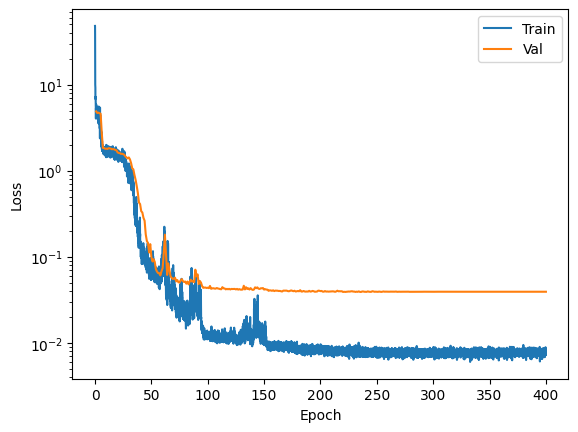

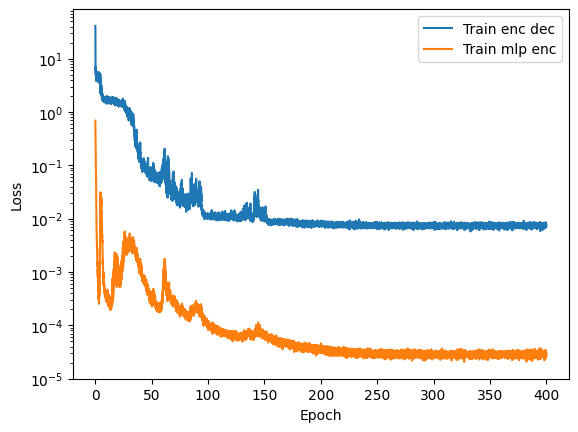

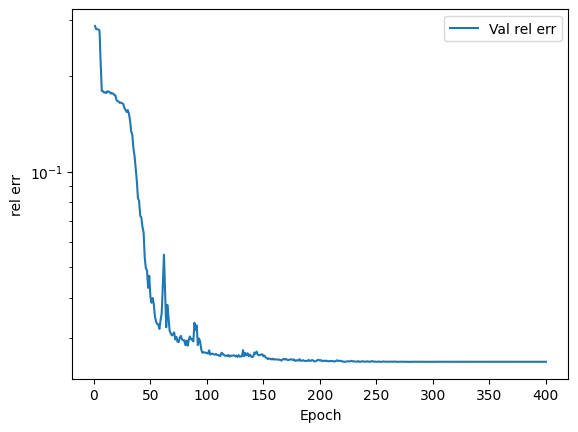

In [ ]:
activation="gelu" #"relu" o "gelu"
pooling="avg" #"max" o "avg"
K_comb=[3,1,1] #o K_comb=[5,1,2]
L_c=2  #1,2, o 3
L_l=2  #1,2, o 3

batch_size=64
num_epochs=400
lr=0.001
#device=torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=MLP_press_ConvAutoencoder_3(activation,pooling,K_comb,L_c,L_l,dim_reduced=128)

# summary(model.mlp.to(device), (3,))
# summary(model.encoder.to(device), (1,39,16))
# summary(model.decoder.to(device), (128,))

# model_trained,  val_loss, val_rel_loss = run_vel_training_encoder_decoder(MLP_press_ConvAutoencoder_4(activation,pooling,K_comb,L_c,L_l,dim_reduced=128),num_epochs, lr, batch_size, device)
# model_trained,  val_loss, val_rel_loss = run_vel_training_encoder_decoder(MLP_press_ConvAutoencoder_3(activation,pooling,K_comb,L_c,L_l,dim_reduced=128),num_epochs, lr, batch_size, device)
# model_trained,  val_loss, val_rel_loss = run_vel_training_encoder_decoder(MLP_press_ConvAutoencoder_2(),num_epochs, lr, batch_size, device)
model_trained,  val_loss, val_rel_loss = run_vel_training_encoder_decoder(MLP_press_ConvAutoencoder_5(dim_reduced=128),num_epochs, lr, batch_size, device)
# model_trained,  val_loss, val_rel_loss = run_vel_training_mlp_pura(MLP_pura(),num_epochs, lr, batch_size, device)



In [ ]:
#find best num_epoch and learning rate

batch_size=32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_losses=[]
val_rel_losses=[]
for lr in list(np.linspace(0.0001, 0.001, 50)):
  for num_epochs in list(np.linspace(50 , 200, 20).astype(int)):

        model_trained,  val_loss, val_rel_loss = run_vel_training_encoder_decoder(num_epochs, lr, batch_size, device)
        val_losses.append(val_loss)
        val_rel_losses.append(val_rel_loss)


In [ ]:
print(device)

In [ ]:

model = Simple_Model()
  # Valori casuali tra 0 e 1
z1, z2, z3= model.forward(train_params,train_vel)

In [ ]:
z1.shape

torch.Size([1560, 18, 8])

In [ ]:
z2.shape

torch.Size([1560, 18, 8])

In [ ]:
z3.shape

torch.Size([1560, 5, 5])

In [ ]:
z=model.predict(train_params)

In [ ]:
z.shape

torch.Size([1560, 5, 5])

In [ ]:
c = torch.randn((5,3,2))
c.shape

torch.Size([5, 3, 2])

In [ ]:
c_shaped=c.view(c.shape[0], -1)

In [ ]:
c_shaped.shape

torch.Size([5, 6])

In [ ]:
c_shaped

tensor([[ 0.0247,  0.5999,  1.3813, -0.8010,  1.7893, -1.3100],
        [-0.0918,  1.5952, -0.1132, -1.1700,  0.2491,  2.2126],
        [-0.3063,  1.1698,  0.2230,  0.6958,  0.5637, -1.1418],
        [ 0.4004,  0.7669,  0.3747,  1.3313,  0.7806,  0.3532],
        [-0.2890,  0.9966,  1.9221,  0.0194, -1.7310,  1.0572]])

In [ ]:
torch.norm(c_shaped, dim=1)

tensor([2.7979, 2.9821, 1.9020, 1.8426, 2.9809])

In [ ]:
def read_vtk(filename):
    """Read .vtk file and return the polydata"""

    fn_dir, fn_ext = os.path.splitext(filename)

    if fn_ext == '.vtk':
        reader = vtk.vtkPolyDataReader()
    elif fn_ext == '.vtp':
        reader = vtk.vtkXMLPolyDataReader()
    elif fn_ext == '.stl':
        reader = vtk.vtkSTLReader()
    elif fn_ext == '.obj':
        reader = vtk.vtkOBJReader()
    elif fn_ext == '.vtu':
        reader = vtk.vtkXMLUnstructuredGridReader()
    elif fn_ext == '.pvtu':
        reader = vtk.vtkXMLPUnstructuredGridReader()
    else:
        raise ValueError(F"File extension {fn_ext} not supported")

    reader.SetFileName(filename)
    reader.Update(0)
    mesh = reader.GetOutput()

    return mesh

def write_vtk(mesh, fn):
    """ Write a mesh (vtk polydata or unstructured grid) to disk """

    _, extension = os.path.splitext(fn)

    if extension == '.vtk':
        writer = vtk.vtkPolyDataWriter()
    elif extension == '.stl':
        writer = vtk.vtkSTLWriter()
    elif extension == '.vtp':
        writer = vtk.vtkXMLPolyDataWriter()
    elif extension == '.vtu':
        writer = vtk.vtkXMLUnstructuredGridWriter()
    elif extension == '.obj':
        writer = vtk.vtkOBJWriter()
    else:
        raise ValueError(f"Unrecognized extension {extension}")

    writer.SetInputData(mesh)
    writer.SetFileName(fn)
    writer.Update(0)
    writer.Write()

    return

def add_array(mesh, array, name):
    """Add numpy array as new field to a vtk file"""

    new_array = numpy_to_vtk(array)
    new_array.SetName(name)
    mesh.GetPointData().AddArray(new_array)

    return mesh

def compute_matching_idxs():
    """Compute correspondences bewteen indices on the .vtu and on the .mesh file for plotting"""

    mesh = read_vtk(os.path.join('/content/drive/MyDrive/data_ML4Science', 'geometries', 'bif_sym_alpha50_h0.10_ref.vtu'))
    points = vtk_to_numpy(mesh.GetPoints().GetData())

    mesh_2 = meshio.read(os.path.join('/content/drive/MyDrive/data_ML4Science', 'geometries','bif_sym_alpha50_h0.10.mesh'))
    points_2 = mesh_2.points

    dist = cdist(mesh_2.points, points, metric='euclidean')

    idxs = np.argmin(dist, axis=0)

    return idxs


def visualize_solution(field_array, fields=None, step_t=10):
    """ Export the solution corresponding to the n-th snapshot (every step_t steps) to a .vtu file."""

    if fields is None:
        fields = {'velocity': 3, 'pressure': 1}  # fields and corresponding dimensions

    os.makedirs('solutions', exist_ok=True)

    idxs = compute_matching_idxs()

    mesh = read_vtk(os.path.join('/content/drive/MyDrive/data_ML4Science', 'geometries', 'bif_sym_alpha50_h0.10.vtu'))

    fom_solution = dict()
    for field in fields:
        # print(f"Processing field {field} - Dimension: {fields[field]}")
        cur_idxs = np.hstack([idxs + k * (Nh_space[field]//fields[field]) for k in range(fields[field])])
        fom_solution[field] = expand(field_array, basis_space[field], basis_time[field])[cur_idxs]
        print(fom_solution[field].shape)

    for cnt_t in range(0, Nh_time['velocity'], step_t):
        # print(f"\nProcessing timestep {cnt_t} of {Nh_time['velocity']}")
        for field in fields:
            cur_fom_solution = np.reshape(fom_solution[field][:, cnt_t], (fields[field], -1)).T
            mesh = add_array(mesh, cur_fom_solution, field)

        # write_vtk(mesh, os.path.join('solutions', f"solution_{n}_{cnt_t}" + '.vtu'))
        write_vtk(mesh, os.path.join('solutions', f"solution_{cnt_t}" + '.vtu'))

    # return
    return fom_solution[field]


<ipython-input-41-a797eeed0b21>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(test_params[index,:], dtype=torch.float32)  # Trasforma in tensore


torch.Size([39, 16])
tensor(2.7389)
(10656, 1000)
(10656, 1000)


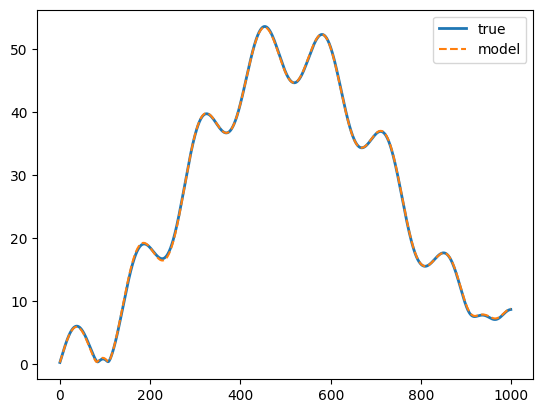

In [ ]:
model_trained.eval()

vel_space_max=vel_space_max.to("cpu")
vel_space_min=vel_space_min.to("cpu")

index=10

input_tensor = torch.tensor(test_params[index,:], dtype=torch.float32)  # Trasforma in tensore
input_tensor = input_tensor.unsqueeze(dim=0)
input_tensor = input_tensor.to(device)  # Se usi la GPU

with torch.no_grad():
    output_visual = model_trained.predict(input_tensor)
    output_visual=output_visual[0]
    print(output_visual.shape)

output_visual=output_visual.to("cpu")
output_visual=output_visual*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min

comparison=test_vel[index]*(1.05*vel_space_max - 0.95*vel_space_min)+0.95*vel_space_min
print(torch.norm(output_visual-comparison)/torch.norm(comparison).item()*100)

fom_vel_true=visualize_solution(comparison.numpy() ,fields={'velocity': 3},step_t=5)
fom_vel_model=visualize_solution(output_visual.numpy() ,fields={'velocity': 3},step_t=5)

mag_fom_vel=np.linalg.norm(fom_vel_true,axis=0)
mag_fom_vel_model=np.linalg.norm(fom_vel_model,axis=0)
plt.figure()
plt.plot(np.arange(1000),mag_fom_vel,label="true",linewidth=2)
plt.plot(np.arange(1000),mag_fom_vel_model,label="model",linestyle='--')
plt.legend()
plt.show()

In [ ]:
!zip -r solutions.zip solutions
from google.colab import files
files.download('solutions.zip')

  adding: solutions/ (stored 0%)
  adding: solutions/solution_25.vtu (deflated 29%)
  adding: solutions/solution_745.vtu (deflated 29%)
  adding: solutions/solution_525.vtu (deflated 29%)
  adding: solutions/solution_265.vtu (deflated 29%)
  adding: solutions/solution_550.vtu (deflated 29%)
  adding: solutions/solution_625.vtu (deflated 29%)
  adding: solutions/solution_500.vtu (deflated 29%)
  adding: solutions/solution_540.vtu (deflated 29%)
  adding: solutions/solution_435.vtu (deflated 29%)
  adding: solutions/solution_965.vtu (deflated 29%)
  adding: solutions/solution_740.vtu (deflated 29%)
  adding: solutions/solution_830.vtu (deflated 29%)
  adding: solutions/solution_365.vtu (deflated 29%)
  adding: solutions/solution_945.vtu (deflated 29%)
  adding: solutions/solution_210.vtu (deflated 29%)
  adding: solutions/solution_810.vtu (deflated 29%)
  adding: solutions/solution_175.vtu (deflated 29%)
  adding: solutions/solution_165.vtu (deflated 29%)
  adding: solutions/solution_255

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>